In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
print(data.head())

                 NVIX  Security
Date                           
1889-07-31  35.131129  8.948479
1889-08-31  32.034896  5.015624
1889-09-30  34.186390  5.757074
1889-10-31  38.383016  5.587853
1889-11-30  34.703040  5.162286


In [3]:
data.index

DatetimeIndex(['1889-07-31', '1889-08-31', '1889-09-30', '1889-10-31',
               '1889-11-30', '1889-12-31', '1890-01-31', '1890-02-28',
               '1890-03-31', '1890-04-30',
               ...
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
               '2016-02-29', '2016-03-31'],
              dtype='datetime64[ns]', name='Date', length=1521, freq=None)

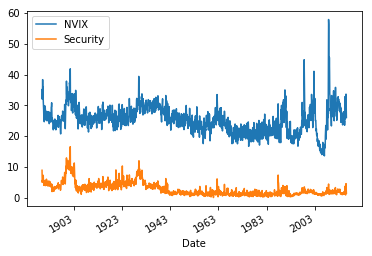

In [4]:
data[['NVIX','Security']].plot()
plt.show()


In [5]:
import statsmodels.api as sm
print(sm.tsa.stattools.adfuller(data['NVIX']))
print(sm.tsa.stattools.adfuller(data['Security']))

(-4.1517814259670605, 0.0007942952873524442, 14, 1506, {'1%': -3.434699589047244, '5%': -2.863461068442911, '10%': -2.5677927524607194}, 6797.4289600966795)
(-2.8604892616336595, 0.050139255815513074, 9, 1511, {'1%': -3.434685171403452, '5%': -2.863454705264858, '10%': -2.5677893640196907}, 3904.437614846582)


In [6]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
#data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data['Security-1'] = data.shift()['Security']
data['NVIX-1'] = data.shift()['NVIX']
data = data[1:]
print(data.head())

                 NVIX  Security  Security-1     NVIX-1
Date                                                  
1889-08-31  32.034896  5.015624    8.948479  35.131129
1889-09-30  34.186390  5.757074    5.015624  32.034896
1889-10-31  38.383016  5.587853    5.757074  34.186390
1889-11-30  34.703040  5.162286    5.587853  38.383016
1889-12-31  35.926694  6.487003    5.162286  34.703040


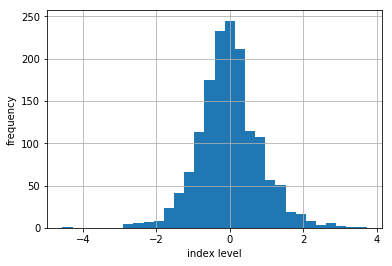

                            OLS Regression Results                            
Dep. Variable:               Security   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     8765.
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        11:08:10   Log-Likelihood:                -1886.8
No. Observations:                1520   AIC:                             3780.
Df Residuals:                    1517   BIC:                             3795.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Security-1     0.8975      0.011     80.172      0.0

In [7]:
X = data[["Security-1", "NVIX", "NVIX-1"]]
y = data["Security"]
#X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
plt.hist(result.resid,bins = 30)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.show()
predictions = result.predict(X)
print(result.summary())


In [8]:
import numpy as np
from arch.univariate import ARX
from arch.univariate import GARCH,StudentsT
y = np.random.randn(100)
arx = ARX(y = data['Security'],x = data[["NVIX", "NVIX-1"]], lags = [1],distribution = StudentsT(), constant = False)
arx.volatility = GARCH(p = 1,o = 1,q = 1, power = 1.0)
res = arx.fit(update_freq=0, disp='off')
print(res.summary())
fc = res.forecast(start = '1889-08-31')

                          AR-X - TARCH/ZARCH Model Results                          
Dep. Variable:                     Security   R-squared:                       0.943
Mean Model:                            AR-X   Adj. R-squared:                  0.943
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -1731.37
Distribution:      Standardized Student's t   AIC:                           3478.74
Method:                  Maximum Likelihood   BIC:                           3521.35
                                              No. Observations:                 1519
Date:                      Wed, Jun 06 2018   Df Residuals:                     1511
Time:                              11:08:15   Df Model:                            8
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
Security[1]  

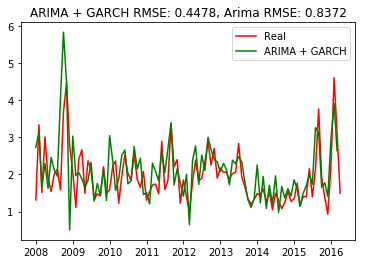

In [9]:
plt.title(('ARIMA + GARCH RMSE: %.4f'% np.sqrt(sum((fc.mean['h.1']['1889-08-31':'2016-02-29'] - data['Security']['1889-08-31':'2016-02-29'] )**2) / len(data['Security'])) + ', Arima RMSE: %.4f'% np.sqrt(sum((predictions - data['Security'])**2) / len(data['Security']))))
#plt.title()
plt.plot(data['Security'][-100:], color='red',label='Real')
plt.plot(fc.mean['h.1'][-100:], color='green',label='ARIMA + GARCH')
#plt.plot(predictions[-50:], color='blue',label='ARIMA')
plt.legend(loc='best')
plt.show()